In [10]:
# Import bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

# Powtarzalność
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
# Wczytanie CSV do pandas
df = pd.read_csv("https://uploads.kodilla.com/bootcamp/ds/19/airline-passengers.csv", usecols=[1])
df.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


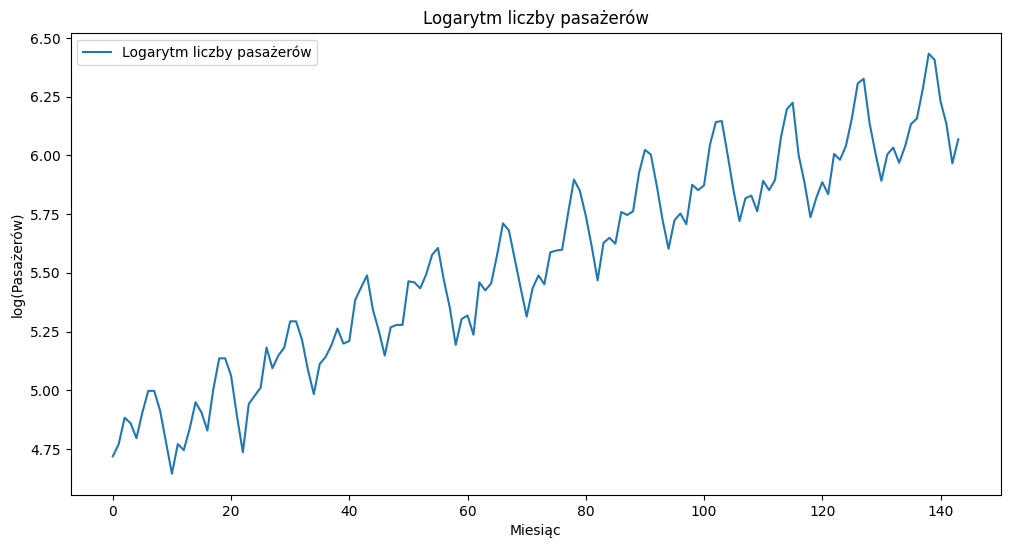

In [12]:
# Logarytmowanie
df_log = np.log(df)
plt.figure(figsize=(12,6))
plt.plot(df_log.values, label="Logarytm liczby pasażerów")
plt.title("Logarytm liczby pasażerów")
plt.xlabel("Miesiąc")
plt.ylabel("log(Pasażerów)")
plt.legend()
plt.show()

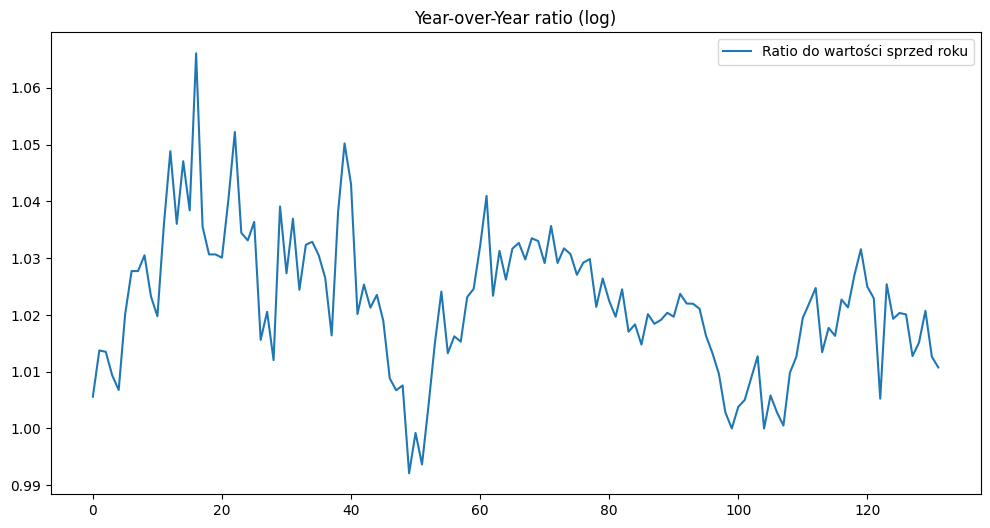

In [13]:
# Obliczenie wartości w stosunku do wartości sprzed roku
df_ratio = df_log / df_log.shift(12)
df_ratio = df_ratio.dropna()
plt.figure(figsize=(12,6))
plt.plot(df_ratio.values, label="Ratio do wartości sprzed roku")
plt.title("Year-over-Year ratio (log)")
plt.legend()
plt.show()

In [14]:
# Standaryzacja
scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(df_ratio.values)
dataset_scaled = dataset_scaled.astype('float32')

In [15]:
# Tworzenie danych
def create_dataset(data, look_back=3):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_dataset(dataset_scaled, look_back)

# Split 80/20
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# reshape [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test,  (X_test.shape[0], X_test.shape[1], 1))

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (103, 3, 1) X_test: (26, 3, 1)


In [16]:
# Funkcja budowania i trenowania modelu
def build_and_train(model_type="RNN", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=100, batch_size=1):

    model = Sequential()

    if model_type=="RNN":
        model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type=="LSTM":
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type=="GRU":
        model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        raise ValueError("model_type musi być 'RNN', 'LSTM' lub 'GRU'")

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), verbose=2, shuffle=False)

    # Prognozy
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Odwrócenie transformacji
    # najpierw od standardyzacji
    train_predict_inv = scaler.inverse_transform(train_predict)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
    test_predict_inv = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

    # RMSE
    train_score = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
    test_score = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

    print(f"{model_type} - RMSE Train: {train_score:.2f}, Test: {test_score:.2f}")

    # Wykres prognoza vs rzeczywiste
    plt.figure(figsize=(12,6))
    plt.plot(y_test_inv, label="Rzeczywiste")
    plt.plot(test_predict_inv, label="Prognoza")
    plt.title(f"{model_type} - Prognoza vs Rzeczywiste")
    plt.legend()
    plt.show()

    return model, history

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 - 2s - 21ms/step - loss: 0.5533 - val_loss: 0.3071
Epoch 2/100
103/103 - 0s - 3ms/step - loss: 0.5114 - val_loss: 0.3005
Epoch 3/100
103/103 - 0s - 3ms/step - loss: 0.5034 - val_loss: 0.3010
Epoch 4/100
103/103 - 0s - 3ms/step - loss: 0.4989 - val_loss: 0.3018
Epoch 5/100
103/103 - 0s - 3ms/step - loss: 0.4955 - val_loss: 0.3027
Epoch 6/100
103/103 - 0s - 3ms/step - loss: 0.4926 - val_loss: 0.3034
Epoch 7/100
103/103 - 0s - 3ms/step - loss: 0.4900 - val_loss: 0.3041
Epoch 8/100
103/103 - 0s - 3ms/step - loss: 0.4877 - val_loss: 0.3047
Epoch 9/100
103/103 - 0s - 3ms/step - loss: 0.4857 - val_loss: 0.3053
Epoch 10/100
103/103 - 0s - 3ms/step - loss: 0.4839 - val_loss: 0.3058
Epoch 11/100
103/103 - 0s - 3ms/step - loss: 0.4824 - val_loss: 0.3061
Epoch 12/100
103/103 - 0s - 4ms/step - loss: 0.4811 - val_loss: 0.3064
Epoch 13/100
103/103 - 1s - 6ms/step - loss: 0.4800 - val_loss: 0.3066
Epoch 14/100
103/103 - 0s - 5ms/step - loss: 0.4790 - val_loss: 0.3066
Epoch 15/100
103/103 - 0s 

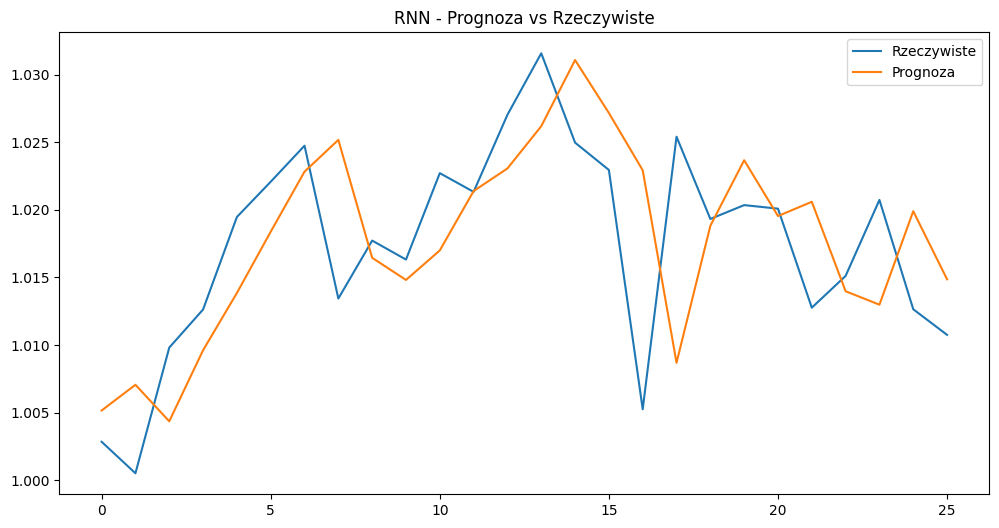

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 - 3s - 25ms/step - loss: 0.8745 - val_loss: 0.3315
Epoch 2/100
103/103 - 1s - 6ms/step - loss: 0.6039 - val_loss: 0.3098
Epoch 3/100
103/103 - 1s - 5ms/step - loss: 0.5796 - val_loss: 0.3050
Epoch 4/100
103/103 - 1s - 6ms/step - loss: 0.5636 - val_loss: 0.2997
Epoch 5/100
103/103 - 0s - 4ms/step - loss: 0.5488 - val_loss: 0.2947
Epoch 6/100
103/103 - 0s - 4ms/step - loss: 0.5357 - val_loss: 0.2900
Epoch 7/100
103/103 - 0s - 3ms/step - loss: 0.5239 - val_loss: 0.2857
Epoch 8/100
103/103 - 0s - 4ms/step - loss: 0.5133 - val_loss: 0.2819
Epoch 9/100
103/103 - 0s - 4ms/step - loss: 0.5037 - val_loss: 0.2788
Epoch 10/100
103/103 - 0s - 4ms/step - loss: 0.4951 - val_loss: 0.2763
Epoch 11/100
103/103 - 0s - 4ms/step - loss: 0.4874 - val_loss: 0.2746
Epoch 12/100
103/103 - 0s - 4ms/step - loss: 0.4805 - val_loss: 0.2738
Epoch 13/100
103/103 - 0s - 4ms/step - loss: 0.4743 - val_loss: 0.2738
Epoch 14/100
103/103 - 1s - 6ms/step - loss: 0.4689 - val_loss: 0.2746
Epoch 15/100
103/103 - 0s 

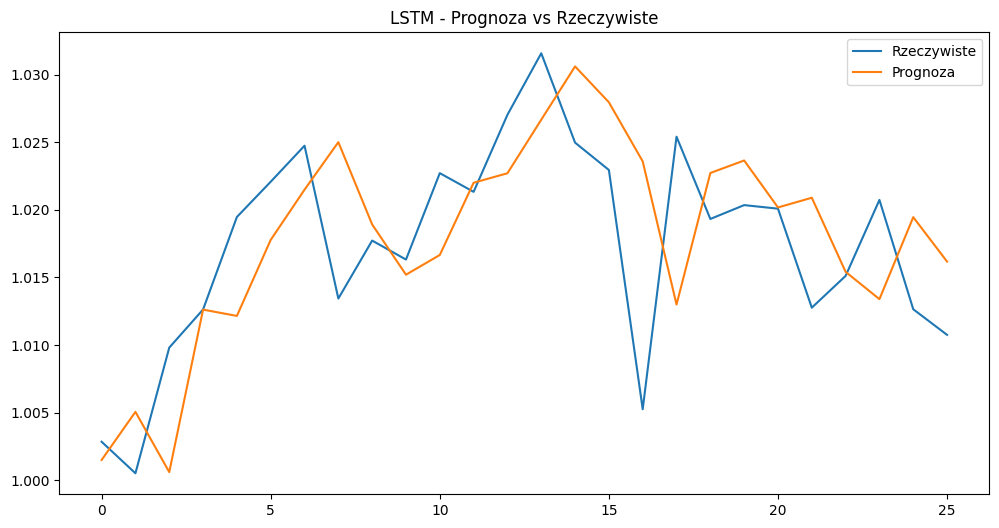

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 - 2s - 22ms/step - loss: 0.7001 - val_loss: 0.2868
Epoch 2/100
103/103 - 0s - 4ms/step - loss: 0.5391 - val_loss: 0.2803
Epoch 3/100
103/103 - 0s - 4ms/step - loss: 0.5199 - val_loss: 0.2755
Epoch 4/100
103/103 - 0s - 4ms/step - loss: 0.5042 - val_loss: 0.2724
Epoch 5/100
103/103 - 0s - 4ms/step - loss: 0.4924 - val_loss: 0.2710
Epoch 6/100
103/103 - 0s - 4ms/step - loss: 0.4834 - val_loss: 0.2709
Epoch 7/100
103/103 - 0s - 4ms/step - loss: 0.4763 - val_loss: 0.2716
Epoch 8/100
103/103 - 1s - 5ms/step - loss: 0.4708 - val_loss: 0.2730
Epoch 9/100
103/103 - 1s - 6ms/step - loss: 0.4664 - val_loss: 0.2748
Epoch 10/100
103/103 - 1s - 6ms/step - loss: 0.4629 - val_loss: 0.2768
Epoch 11/100
103/103 - 1s - 6ms/step - loss: 0.4602 - val_loss: 0.2788
Epoch 12/100
103/103 - 1s - 5ms/step - loss: 0.4580 - val_loss: 0.2807
Epoch 13/100
103/103 - 0s - 4ms/step - loss: 0.4563 - val_loss: 0.2825
Epoch 14/100
103/103 - 0s - 4ms/step - loss: 0.4549 - val_loss: 0.2841
Epoch 15/100
103/103 - 0s 

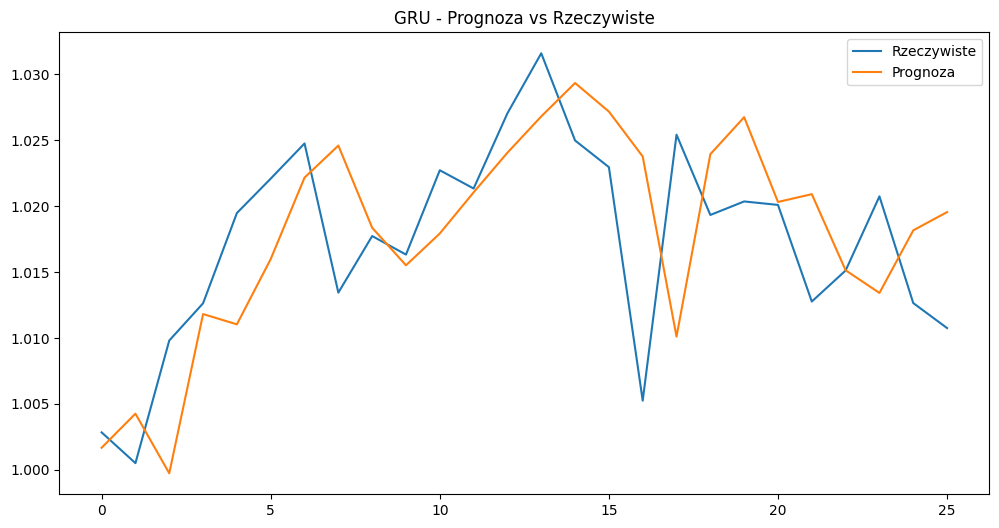

In [17]:
# Trening
rnn_model, rnn_history = build_and_train("RNN")
lstm_model, lstm_history = build_and_train("LSTM")
gru_model, gru_history = build_and_train("GRU")

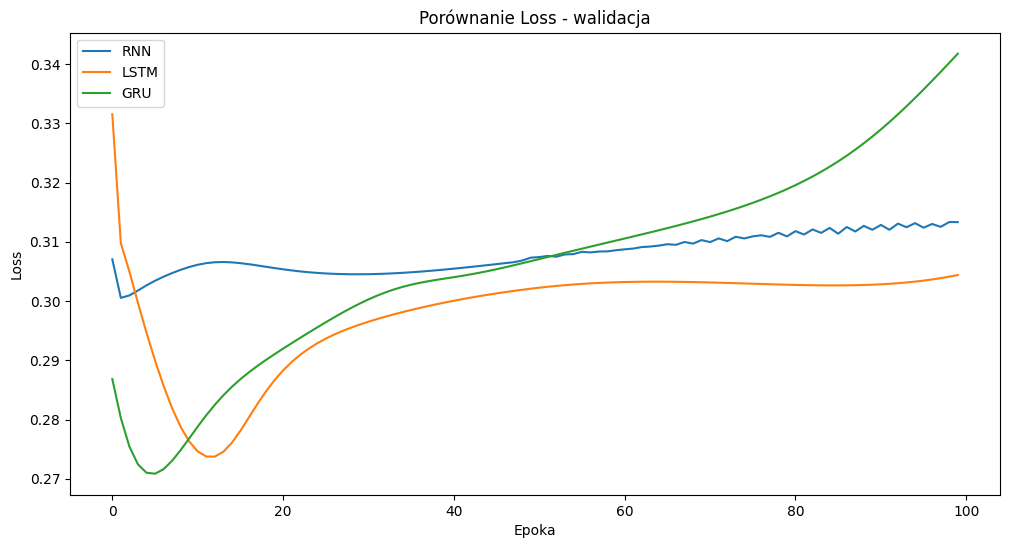

In [18]:
# Wyniki
plt.figure(figsize=(12,6))
plt.plot(rnn_history.history['val_loss'], label='RNN')
plt.plot(lstm_history.history['val_loss'], label='LSTM')
plt.plot(gru_history.history['val_loss'], label='GRU')
plt.title("Porównanie Loss - walidacja")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.show()